## Import required packages

In [1]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import warnings
from IPython.display import display
from sklearn.utils import resample

## Import dataset

### Setting up KaggleAPI


**Kaggle API Token**

In order to use the Kaggle’s public API, you must first authenticate using an API token.

On Kaggle, go to 'Your Profile' > 'Settings' > 'Account' tab > 'API' section and select 'Create New Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials.

If you are using the Kaggle CLI tool, the tool will look for this token at `~/.kaggle/kaggle.json` on Linux, OSX, and other UNIX-based operating systems, and at `C:\Users\<Windows-username>\.kaggle\kaggle.json` on Windows. If the token is not there, an error will be raised. Hence, once you’ve downloaded the token, you should move it from your Downloads folder to this folder.

If you are using the Kaggle API directly, where you keep the token doesn’t matter, so long as you are able to provide your credentials at runtime.

### Downloading dataset using KaggleAPI

_Disclamer: This might take some time due to the size of the dataset._

In [2]:
# Check if 'Base.csv' exists before downloading and extracting the dataset
if not os.path.exists('../data/raw/Base.csv'):
    # Initialize Kaggle API
    api = KaggleApi()
    # Authenticate with your Kaggle API credentials
    api.authenticate()

    # Set the name of the dataset on Kaggle
    dataset_name = 'sgpjesus/bank-account-fraud-dataset-neurips-2022'
    # Set the destination path where you want to save the dataset
    destination_path = '../data/raw'


    # Create the destination directory if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)
    # Download the dataset
    api.dataset_download_files(dataset_name, path=destination_path, unzip=True)

    ## In case file is still zipped:
    # Define the path to the dataset zip file and the directory for extraction
    zip_file_path = '../data/raw/bank-account-fraud-dataset-neurips-2022.zip'
    # Check if the dataset zip file exists
    if os.path.exists(zip_file_path):
        # Extract the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall('../data/raw/')

### Reading in dataset

In [3]:
# Read the CSV file into a DataFrame
data = pd.read_csv('../data/raw/Base.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

## Data cleaning

### Conversion of variable data types

Converting multi-categorical variables from Dtype `object` to Dtype `category`.

In [5]:
# Convert the variables to the appropriate data types
data['fraud_bool'] = data['fraud_bool'].astype('category')
data['payment_type'] = data['payment_type'].astype('category')
data['employment_status'] = data['employment_status'].astype('category')
data['housing_status'] = data['housing_status'].astype('category')
data['source'] = data['source'].astype('category')
data['device_os'] = data['device_os'].astype('category')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype   
---  ------                            --------------    -----   
 0   fraud_bool                        1000000 non-null  category
 1   income                            1000000 non-null  float64 
 2   name_email_similarity             1000000 non-null  float64 
 3   prev_address_months_count         1000000 non-null  int64   
 4   current_address_months_count      1000000 non-null  int64   
 5   customer_age                      1000000 non-null  int64   
 6   days_since_request                1000000 non-null  float64 
 7   intended_balcon_amount            1000000 non-null  float64 
 8   payment_type                      1000000 non-null  category
 9   zip_count_4w                      1000000 non-null  int64   
 10  velocity_6h                       1000000 non-null  float64 
 11  velocity_24h             

### Removal of irrelevant variables

Observing the dataset to find any irrelevant variables

In [7]:
pd.set_option('display.max_columns', None)
data.describe(include='all')

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000,1000000.000000,1000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
unique,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,5,NaN,NaN,NaN,NaN
top,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AB,NaN,NaN,NaN,NaN,NaN,NaN,CA,NaN,NaN,BC,NaN,NaN,NaN,NaN,NaN,NaN,INTERNET,NaN,other,NaN,NaN,NaN,NaN
freq,988971.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370554,NaN,NaN,NaN,NaN,NaN,NaN,730252,NaN,NaN,372143,NaN,NaN,NaN,NaN,NaN,NaN,992952,NaN,342728,NaN,NaN,NaN,NaN
mean,NaN,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,NaN,1572.692049,5665.296605,4769.781965,4856.324016,184.361849,9.503544,NaN,130.989595,0.529886,NaN,0.417077,0.889676,10.839303,0.222988,515.851010,0.025242,NaN,7.544940,NaN,0.576947,1.018312,0.0,3.288674
std,NaN,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,NaN,1005.374565,3009.380665,1479.212612,919.843934,459.625329,5.033792,NaN,69.681812,0.499106,NaN,0.493076,0.313293,12.116875,0.416251,487.559902,0.156859,NaN,8.033106,NaN,0.494044,0.180761,0.0,2.209994
min,NaN,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,NaN,1.000000,-170.603072,1300.307314,2825.748405,0.000000,0.000000,NaN,-170.000000,0.000000,NaN,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,NaN,-1.000000,NaN,0.000000,-1.000000,0.0,0.000000
25%,NaN,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,NaN,894.000000,3436.365848,3593.179135,4268.368423,1.000000,6.000000,NaN,83.000000,0.000000,NaN,0.000000,1.000000,-1.000000,0.000000,200.000000,0.000000,NaN,3.103053,NaN,0.000000,1.000000,0.0,1.000000
50%,NaN,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,NaN,1263.000000,5319.769349,4749.921161,4913.436941,9.000000,9.000000,NaN,122.000000,1.000000,NaN,0.000000,1.000000,5.000000,0.000000,200.000000,0.000000,NaN,5.114321,NaN,1.000000,1.000000,0.0,3.000000
75%,NaN,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,NaN,1944.000000,7680.717827,5752.574191,5488.083356,25.000000,13.000000,NaN,178.000000,1.000000,NaN,1.000000,1.000000,25.000000,0.000000,500.000000,0.000000,NaN,8.866131,NaN,1.000000,1.000000,0.0,5.000000


From observations, `device_fraud_count` column only contain a single unique value which means that it is redundant in fraud detection as the values are same across all instances. As such, the column is dropped from the dataset.

In [8]:
# Checking unique values for `device_fraud_count` column
print(np.unique(data['device_fraud_count']))

[0]


In [9]:
# Remove the 'device_fraud_count' column
data.drop(columns=['device_fraud_count'], inplace=True)

### Handling of missing values

Detailed information (datasheet) on dataset: https://github.com/feedzai/bank-account-fraud/blob/main/documents/datasheet.pdf

The following numerical variables contain missing values reflected as negative values:
+ `prev_address_months_count`
+ `current_address_months_count`
+ `intended_balcon_amount`
+ `bank_months_count`
+ `session_length_in_minutes`
+ `device_distinct_emails`

Observing the proportion of missing values

In [10]:
# Columns with potential missing values
na_cols = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'session_length_in_minutes', 'device_distinct_emails_8w']

# Check for missing values, if values are -1 or negative, they are considered missing
# If data is negative, it is considered missing
missing = data.loc[:, na_cols]
missing[missing < 0] = np.nan
missing.isnull().sum()

# Create dataframe with na_counts, na_percentage
missing_info = missing.isnull().sum().to_frame(name='na_counts')
missing_info['na_proportion'] = round((missing_info['na_counts'] / data.shape[0])*100, 2)
print(missing_info)

                              na_counts  na_proportion
prev_address_months_count        712920          71.29
current_address_months_count       4254           0.43
intended_balcon_amount           742523          74.25
session_length_in_minutes          2015           0.20
device_distinct_emails_8w           359           0.04


In [11]:
# concat "missing" with data['fraud_bool'] along columns
missing_data = pd.concat([missing, data['fraud_bool']], axis=1)
total_fraud_count = len(missing_data[missing_data['fraud_bool'] == 1]) # 11,029

# prev_address_months_count
prev_address_months_count_missing = missing_data[missing_data['prev_address_months_count'].isnull()].groupby('fraud_bool')
print("Column: prev_address_months_count")
print(prev_address_months_count_missing.size()) # 10134/11029 = 91.8% fraud cases
print("Fraud % : ", (len(prev_address_months_count_missing.get_group(1)) / total_fraud_count) * 100, "%")
print("\n")

# current_address_months_count
current_address_months_count_missing = missing_data[missing_data['current_address_months_count'].isnull()].groupby('fraud_bool')
print("Column: current_address_months_count")
print(current_address_months_count_missing.size()) # 10134/11029 = 91.8% fraud cases
print("Fraud % : ", (len(current_address_months_count_missing.get_group(1)) / total_fraud_count) * 100, "%")
print("\n")

# intended_balcon_amount
intended_balcon_amount_missing = missing_data[missing_data['intended_balcon_amount'].isnull()].groupby('fraud_bool')
print("Column: intended_balcon_amount")
print(intended_balcon_amount_missing.size()) # 10134/11029 = 91.8% fraud cases
print("Fraud % : ", (len(intended_balcon_amount_missing.get_group(1)) / total_fraud_count) * 100, "%")
print("\n")

# session_length_in_minutes
session_length_in_minutes_missing = missing_data[missing_data['session_length_in_minutes'].isnull()].groupby('fraud_bool')
print("Column: session_length_in_minutes")
print(session_length_in_minutes_missing.size()) # 10134/11029 = 91.8% fraud cases
print("Fraud % : ", (len(session_length_in_minutes_missing.get_group(1)) / total_fraud_count) * 100, "%")
print("\n")

# device_distinct_emails_8w
device_distinct_emails_8w_missing = missing_data[missing_data['device_distinct_emails_8w'].isnull()].groupby('fraud_bool')
print("Column: device_distinct_emails_8w")
print(device_distinct_emails_8w_missing.size()) # 10134/11029 = 91.8% fraud cases
print("Fraud % : ", (len(device_distinct_emails_8w_missing.get_group(1)) / total_fraud_count) * 100, "%")
print("\n")

# combination of missing values (prev_address_months_count & intended_balcon_amount)
combination_missing = missing_data[(missing_data['prev_address_months_count'].isnull()) & (missing_data['intended_balcon_amount'].isnull())].groupby('fraud_bool')
print("Column: prev_address_months_count & intended_balcon_amount")
print(combination_missing.size()) # 10134/11029 = 91.8% fraud cases
print("Fraud % : ", (len(combination_missing.get_group(1)) / total_fraud_count) * 100, "%")
print("\n")


Column: prev_address_months_count
fraud_bool
0    702786
1     10134
dtype: int64
Fraud % :  91.88503037446732 %


Column: current_address_months_count
fraud_bool
0    4240
1      14
dtype: int64
Fraud % :  0.12693807235470125 %


Column: intended_balcon_amount
fraud_bool
0    732776
1      9747
dtype: int64
Fraud % :  88.37609937437665 %


Column: session_length_in_minutes
fraud_bool
0    1997
1      18
dtype: int64
Fraud % :  0.16320609302747305 %


Column: device_distinct_emails_8w
fraud_bool
0    355
1      4
dtype: int64
Fraud % :  0.03626802067277178 %


Column: prev_address_months_count & intended_balcon_amount
fraud_bool
0    513606
1      8943
dtype: int64
Fraud % :  81.08622721914952 %




**Conclusion on Missing Values Analysis**

| Columns with Missing Values | % of Fraud Cases that have missing values | % of Non-Fraud Cases that have missing values |
|:----------------------------|:------------------------------------------|:----------------------------------------------|
| prev_address_months_count | 91.8% | 71.1% |
| current_address_months_count | 0.44% | 1.39% |
| intended_balcon_amount | 88.4% | 74.1% |
| session_length_in_minutes | 0.16% | 0.20% |
| device_distinct_emails_8w | 1.41% | 0.66% |

* Insights:
    * Ok to remove rows with missing values in columns `current_address_months_count` and `session_length_in_minutes` and `device_distinct_emails_8w` because a small proportion of fraud cases are in these missing values.
    * If other columns have missing values, it could be a pattern for fraud.
    * **81.1%** of fraud cases have `prev_address_months_count` and `intended_balcon_amount` as missing values, compared to only **51.9%** of all non-fraud cases as missing values.

After analysis, the missing values in the dataset are handled as such:
1. Change all negative values to -1 for column `intended_balcon_amount`.
2. Drop rows with missing values in columns:
    * `current_address_months_count`
    * `session_length_in_minutes`
    * `device_distinct_emails_8w`

In [12]:
# change all negative values to -1 for intended_balcon_amount
data['intended_balcon_amount'] = data['intended_balcon_amount'].apply(lambda x: -1 if x < 0 else x)

# for rows with values < 0 in 'current_address_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w', drop them
data = data[(data['current_address_months_count'] >= 0) & (data['session_length_in_minutes'] >= 0) & (data['device_distinct_emails_8w'] >= 0)]

In [13]:
data

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0
1,0,0.8,0.617426,-1,89,20,0.010095,-1.000000,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.000000,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.000000,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.8,0.124690,-1,143,30,0.051348,-1.000000,AB,530,6732.602414,3010.048099,3095.754245,42,8,CA,305,1,BB,1,1,31,0,1500.0,0,INTERNET,16.967770,other,0,1,7
999996,0,0.9,0.824544,-1,193,30,0.009591,0.008307,AC,408,1574.293294,2716.495767,4286.089050,0,5,CA,235,0,BA,1,1,-1,1,1000.0,0,INTERNET,1.504109,macintosh,0,1,7
999997,0,0.8,0.140891,-1,202,10,0.059287,50.609995,AA,749,1258.864938,3601.322892,3103.891664,2,3,CA,195,1,BE,0,1,31,0,200.0,0,INTERNET,16.068595,other,0,1,7
999998,0,0.9,0.002480,52,3,30,0.023357,-1.000000,AB,707,7048.137128,6521.395012,3068.265084,7,8,CA,148,0,BD,0,1,1,0,200.0,0,INTERNET,1.378683,linux,1,1,7


## Data sampling

### Undersampling of imbalanced dataset

In [14]:
# Observing proportion of labelled data
print(data.groupby('fraud_bool').size())
print()
print(
    "ratio = 1:", round(len(data[data['fraud_bool'] == 0]) / len(data[data['fraud_bool'] == 1]), 2)
    )

fraud_bool
0    982612
1     10995
dtype: int64

ratio = 1: 89.37


**Undersampling ratio analysis**

To address the dataset's imbalance, we aim to decrease the disproportion between fraudulent and non-fraudulent cases for a more balanced dataset by undersampling non-fraudulent instances. To determine the most effective ratio for the undersampled data, we conducted a comparison of results across datasets featuring different label ratios.

**Logistic Regression**

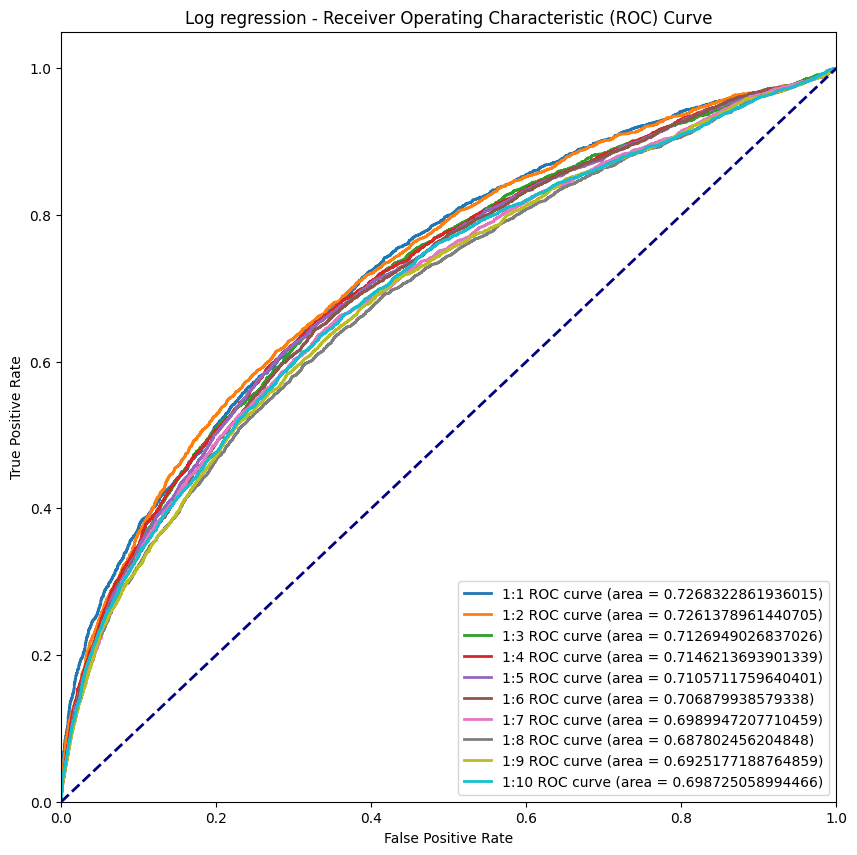

  Model  Accuracy  Precision    Recall  F1 Score
0   1:1  0.663332   0.668099  0.656212  0.662103
1   1:2  0.720897   0.624097  0.417572  0.500362
2   1:3  0.766864   0.579265  0.287811  0.384554
3   1:4  0.809737   0.666667  0.129917  0.217456
4   1:5  0.838765   0.603376  0.086957  0.152006
5   1:6  0.859939   0.600671  0.054341  0.099666
6   1:7  0.877785   0.526882  0.060401  0.108377
7   1:8  0.890592   0.613445  0.022290  0.043017
8   1:9  0.901016   0.673267  0.020606  0.039988
9  1:10  0.910098   0.613793  0.027011  0.051744


In [15]:
result_label_LR = []
accuracydata_result_LR = []
precisiondata_result_LR = []
recalldata_result_LR = []
fprdata_result_LR = []
tprdata_result_LR = []
thresholdsdata_result_LR = []
roc_aucdata_result_LR = []

### ONE HOT ENCONDING OF CAT VARIABLE
dff_label = data['fraud_bool']
# Split data into numerical and categorical
df_cat = data.drop(columns='fraud_bool').select_dtypes(include=['category'])
df_num = data.drop(columns='fraud_bool').select_dtypes(exclude=['category'])
# One hot encoding for categorical data
df_cat_hot = pd.get_dummies(df_cat)
# combine numerical and one hot encoded categorical data
dff = pd.concat([df_num, df_cat_hot, dff_label], axis=1)

# Suppress warnings
warnings.filterwarnings("ignore")

### TESTING MODEL ACCURACY OVER DIFFEENT SAMPLING RATIO
for i in range(1, 11):
    ### UNDERSAMPLING
    # separate fraud and non-fraud data
    fraud = dff[dff['fraud_bool'] == 1]
    not_fraud = dff[dff['fraud_bool'] == 0]

    # Randomly sample non-fraud data to create a balanced dataset
    undersampled_not_fraud = not_fraud.sample(n=len(fraud)*i, random_state=42)

    # Combine fraud and undersampled non-fraud data
    downsize_dff = pd.concat([fraud, undersampled_not_fraud], axis=0)

    # Assuming X  = features and y = labels
    label = "1:" + str(i)
    X = downsize_dff.drop(columns='fraud_bool')
    y = downsize_dff['fraud_bool']

    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Step 2: Create and train the gradient boosting classifier
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Step 3: Make predictions
    y_pred = model.predict(X_test)

    # Step 4: Calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Step 5: Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)


    result_label_LR.append(label)
    accuracydata_result_LR.append(accuracy)
    precisiondata_result_LR.append(precision)
    recalldata_result_LR.append(recall)
    fprdata_result_LR.append(fpr)
    tprdata_result_LR.append(tpr)
    thresholdsdata_result_LR.append(thresholds)
    roc_aucdata_result_LR.append(roc_auc)


### RESULTS VISUALISATION
plt.figure(figsize=(10, 10))
for i in range(len(result_label_LR)):
    plt.plot(fprdata_result_LR[i], tprdata_result_LR[i], lw=2, label='{0} ROC curve (area = {1})'.format(result_label_LR[i], roc_aucdata_result_LR[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log regression - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

results_df = pd.DataFrame({
    'Model': result_label_LR,
    'Accuracy': accuracydata_result_LR,
    'Precision': precisiondata_result_LR,
    'Recall': recalldata_result_LR,
    'F1 Score' : [(2 * p * r) / (p + r) for p, r in zip(precisiondata_result_LR, recalldata_result_LR)]
})

# Display the DataFrame
print(results_df)

warnings.resetwarnings()

**Gradient Boost**

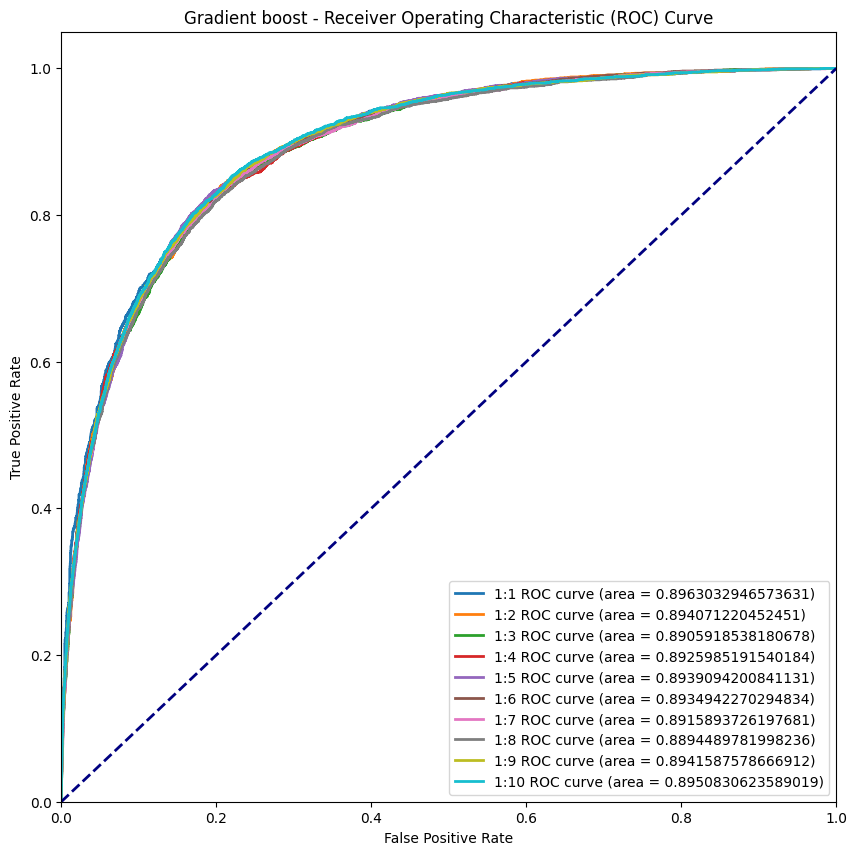

  Model  Accuracy  Precision    Recall  F1 Score
0   1:1  0.811429   0.819162  0.801870  0.810424
1   1:2  0.826698   0.792384  0.653382  0.716201
2   1:3  0.845233   0.762870  0.563642  0.648295
3   1:4  0.864730   0.754180  0.497318  0.599389
4   1:5  0.878581   0.723061  0.436607  0.544455
5   1:6  0.892594   0.724614  0.398604  0.514297
6   1:7  0.903630   0.709928  0.365794  0.482815
7   1:8  0.910398   0.699029  0.329771  0.448133
8   1:9  0.917811   0.700204  0.312121  0.431775
9  1:10  0.924292   0.699128  0.291958  0.411903


In [16]:
result_label_GB = []
accuracydata_result_GB = []
precisiondata_result_GB = []
recalldata_result_GB = []
fprdata_result_GB = []
tprdata_result_GB = []
thresholdsdata_result_GB = []
roc_aucdata_result_GB = []

### ONE HOT ENCONDING OF CAT VARIABLE
dff_label = data['fraud_bool']
# Split data into numerical and categorical
df_cat = data.drop(columns='fraud_bool').select_dtypes(include=['category'])
df_num = data.drop(columns='fraud_bool').select_dtypes(exclude=['category'])
# One hot encoding for categorical data
df_cat_hot = pd.get_dummies(df_cat)
# combine numerical and one hot encoded categorical data
dff = pd.concat([df_num, df_cat_hot, dff_label], axis=1)

# Suppress warnings
warnings.filterwarnings("ignore")

### TESTING MODEL ACCURACY OVER DIFFEENT SAMPLING RATIO
for i in range(1, 11):
    ### UNDERSAMPLING
    # separate fraud and non-fraud data
    fraud = dff[dff['fraud_bool'] == 1]
    not_fraud = dff[dff['fraud_bool'] == 0]

    # Randomly sample non-fraud data to create a balanced dataset
    undersampled_not_fraud = not_fraud.sample(n=len(fraud)*i, random_state=42)

    # Combine fraud and undersampled non-fraud data
    downsize_dff = pd.concat([fraud, undersampled_not_fraud], axis=0)

    # Assuming X  = features and y = labels
    label = "1:" + str(i)
    X = downsize_dff.drop(columns='fraud_bool')
    y = downsize_dff['fraud_bool']

    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Step 2: Create and train the gradient boosting classifier
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)

    # Step 3: Make predictions
    y_pred = model.predict(X_test)

    # Step 4: Calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Step 5: Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)


    result_label_GB.append(label)
    accuracydata_result_GB.append(accuracy)
    precisiondata_result_GB.append(precision)
    recalldata_result_GB.append(recall)
    fprdata_result_GB.append(fpr)
    tprdata_result_GB.append(tpr)
    thresholdsdata_result_GB.append(thresholds)
    roc_aucdata_result_GB.append(roc_auc)


### RESULTS VISUALISATION
plt.figure(figsize=(10, 10))
for i in range(len(result_label_GB)):
    plt.plot(fprdata_result_GB[i], tprdata_result_GB[i], lw=2, label='{0} ROC curve (area = {1})'.format(result_label_GB[i], roc_aucdata_result_GB[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient boost - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

results_df = pd.DataFrame({
    'Model': result_label_GB,
    'Accuracy': accuracydata_result_GB,
    'Precision': precisiondata_result_GB,
    'Recall': recalldata_result_GB,
    'F1 Score' : [(2 * p * r) / (p + r) for p, r in zip(precisiondata_result_GB, recalldata_result_GB)]
})

# Display the DataFrame
print(results_df)


warnings.resetwarnings()

**Distribution of undersampled data**

To verify any loss of information from undersampling, we observe the difference in distribution of variable after undersampling.

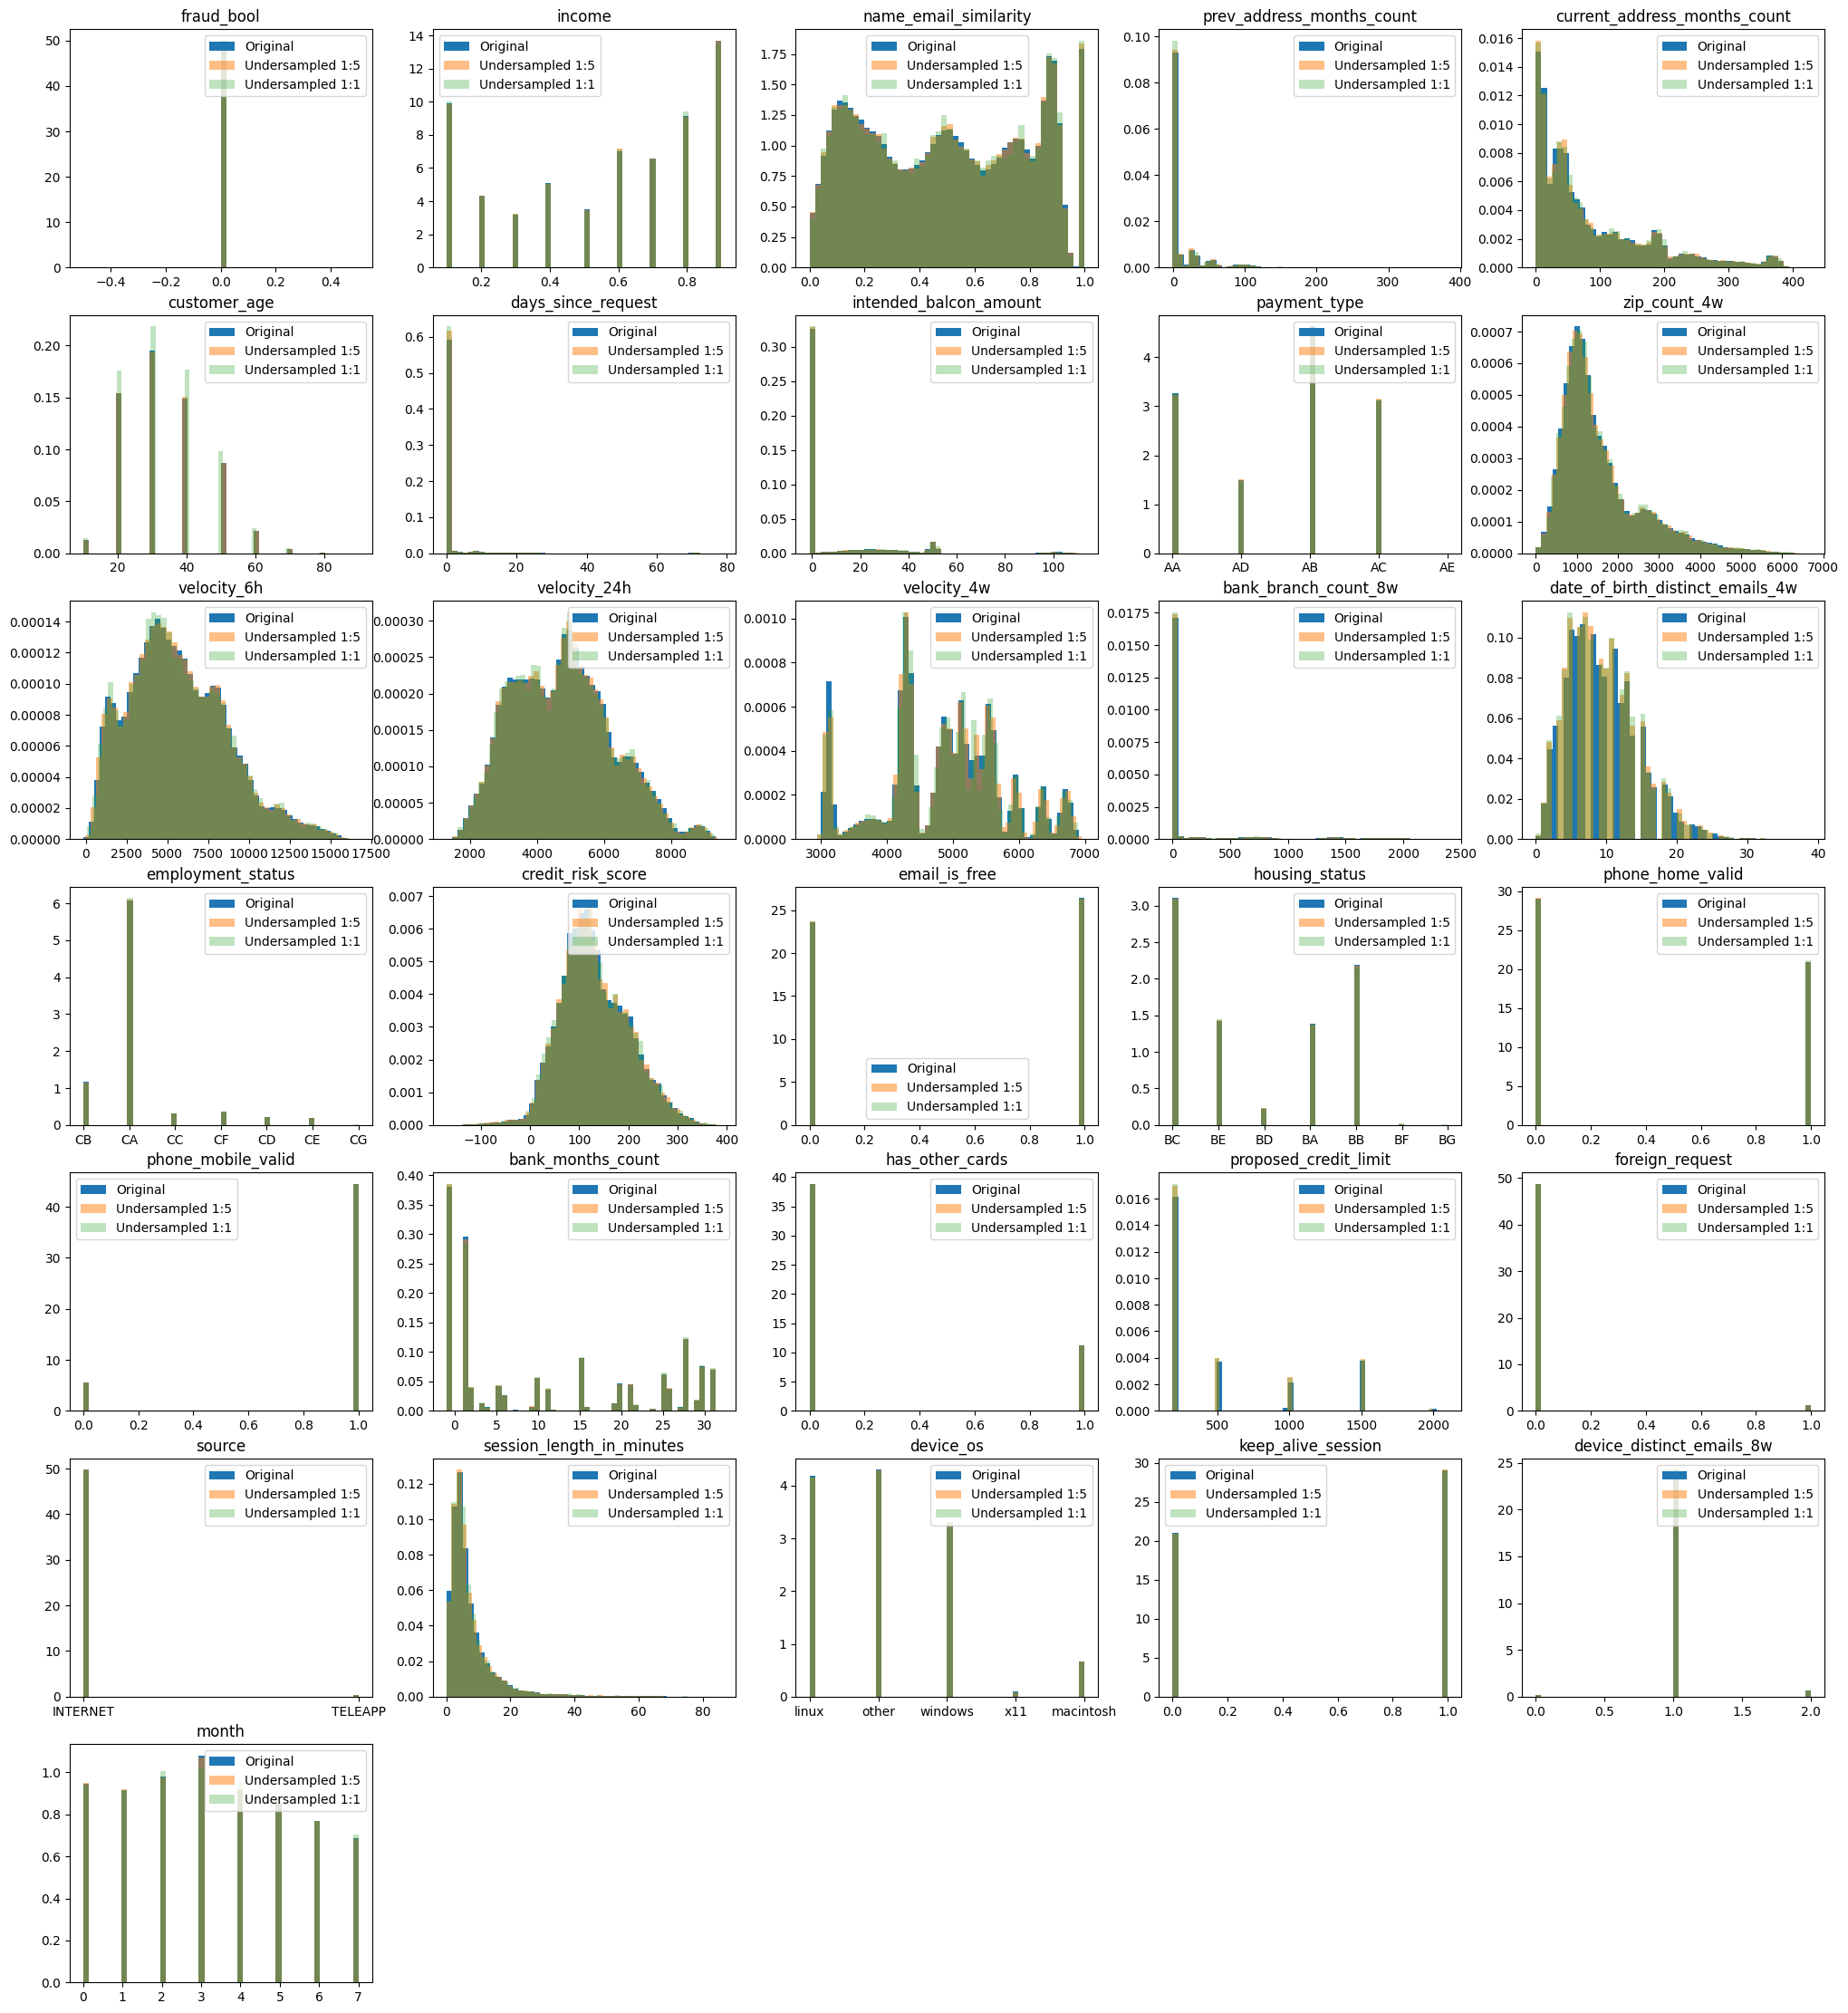

In [17]:
fraud_data = data[data['fraud_bool'] == 1]
non_fraud_data = data[data['fraud_bool'] == 0]

undersampled_not_fraud_1_1 = resample(non_fraud_data, replace=False, n_samples=len(fraud_data), random_state=42)
undersampled_not_fraud_1_5 = resample(non_fraud_data, replace=False, n_samples=5*len(fraud_data), random_state=42)

plt.figure(figsize=(25, 4 * ((len(non_fraud_data.columns) // 5 ) + 1)))

for i, col in enumerate(non_fraud_data.columns):
    plt.subplot(((len(non_fraud_data.columns) // 5 ) + 1) , 5, i+1)
    plt.hist(non_fraud_data[col], bins=50, alpha=1, label='Original', density=True)
    plt.hist(undersampled_not_fraud_1_5[col], bins=50, alpha=0.5, label='Undersampled 1:5', density=True)
    plt.hist(undersampled_not_fraud_1_1[col], bins=50, alpha=0.3, label='Undersampled 1:1', density=True)
    plt.title(col)
    plt.legend()

**Undersampling conclusion**

Looking at the results of the ROC-AUC, we conclude that the difference in sampling ratio is neligible. However, when comparing the distribution of undersampled data to orignal data, we can observe that there is a significant loss of information with a low undersampling ratio. As such to strike a balance between addressing class imbalance, preserving information and ensuring computational efficiency, we chose a more balanced ratio of 1:5 for undersampling.

In [18]:
# Separate fraud and non-fraud data
fraud_data = data[data['fraud_bool'] == 1]
non_fraud_data = data[data['fraud_bool'] == 0]

# Undersample non-fraud data to match the size of the fraud data
undersampled_non_fraud_data = resample(non_fraud_data, replace=False, n_samples=5*len(fraud_data), random_state=42)

# Combine fraud and undersampled non-fraud data
undersampled_data = pd.concat([fraud_data, undersampled_non_fraud_data])

## Save processed data

In [19]:
undersampled_data

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
43,1,0.9,0.570800,-1,157,60,0.005908,35.337538,AA,4079,8139.265753,4312.230612,6341.431598,2,17,CA,131,1,BA,1,1,30,0,1500.0,0,INTERNET,4.036394,windows,1,1,0
140,1,0.1,0.993219,-1,67,20,0.015331,92.120139,AA,1192,8330.727428,6708.346918,6709.436651,37,6,CA,79,1,BB,0,1,25,0,1500.0,0,INTERNET,12.928072,windows,0,1,0
284,1,0.8,0.794351,-1,376,60,17.925951,41.422110,AA,815,9747.407396,6902.019628,6467.154127,46,3,CC,196,1,BA,1,0,28,0,1500.0,0,INTERNET,2.550167,linux,0,1,0
314,1,0.7,0.090000,-1,58,50,0.004134,-1.000000,AD,4011,8036.901841,5794.624929,6333.335164,2,6,CA,177,1,BA,0,1,27,0,1500.0,0,INTERNET,3.500856,windows,0,1,0
561,1,0.9,0.998248,31,45,30,0.010165,33.067538,AA,525,6883.814598,3655.042385,4327.215795,16,12,CA,273,1,BA,0,1,1,1,2000.0,0,INTERNET,44.536211,windows,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438477,0,0.5,0.229726,-1,77,30,0.023810,51.035510,AB,600,5013.010793,5230.918843,4219.735288,14,4,CA,141,0,BC,0,1,2,0,1000.0,0,INTERNET,3.494473,other,0,1,3
130875,0,0.7,0.346851,-1,267,30,0.037950,-1.000000,AD,3302,5819.919542,6168.258546,5966.000427,13,18,CB,187,1,BA,0,1,15,0,200.0,0,INTERNET,16.715031,windows,0,1,0
82250,0,0.1,0.713909,-1,39,20,0.017796,-1.000000,AB,1328,6739.636163,5381.213987,4349.733114,11,10,CA,96,0,BB,1,1,25,0,200.0,0,INTERNET,4.672190,other,1,1,0
743454,0,0.5,0.264979,-1,74,30,0.023085,-1.000000,AC,1186,6291.887632,3745.961464,4264.554106,0,5,CA,80,1,BB,1,1,-1,0,200.0,0,INTERNET,2.127478,other,0,1,5


In [20]:
undersampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65970 entries, 43 to 376045
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   fraud_bool                        65970 non-null  category
 1   income                            65970 non-null  float64 
 2   name_email_similarity             65970 non-null  float64 
 3   prev_address_months_count         65970 non-null  int64   
 4   current_address_months_count      65970 non-null  int64   
 5   customer_age                      65970 non-null  int64   
 6   days_since_request                65970 non-null  float64 
 7   intended_balcon_amount            65970 non-null  float64 
 8   payment_type                      65970 non-null  category
 9   zip_count_4w                      65970 non-null  int64   
 10  velocity_6h                       65970 non-null  float64 
 11  velocity_24h                      65970 non-null  fl

In [21]:
# Check if 'Base.csv' exists before downloading and extracting the dataset
if not os.path.exists('../data/processed/undersampled_data.csv'):

    # Create the destination directory if it doesn't exist
    os.makedirs('../data/processed', exist_ok=True)

    # save the undersampled data to a CSV file
    undersampled_data.to_csv('../data/processed/undersampled_data.csv', index=False)

### Train-Test Data Split

In [22]:
# Splitting the dataset into features (X) and target variable (y)
X = undersampled_data.drop(columns=['fraud_bool'])
y = undersampled_data['fraud_bool']

# Splitting the dataset into training and test sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the training and test sets to CSV files
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)


## Data Processing without Analysis

Run this cell only to obtain all data files directly

In [24]:
import sys
sys.path.append('../scripts')
import data_preprocessing

data_preprocessing.data_preprocessing()

Data Preprocessing...
Data Preprocessing completed successfully. Data saved to 'data/processed/undersampled_data.csv'.
Splitting the dataset into train-test subset...
Train-test split completed successfully. Data saved to 'data/processed/X_train.csv', 'data/processed/X_test.csv', 'data/processed/y_train.csv', and 'data/processed/y_test.csv'.
